<a href="https://colab.research.google.com/github/every1218/Book/blob/main/%EB%B0%91%EB%B0%94%EB%8B%A5%EB%B6%80%ED%84%B0%20%EC%8B%9C%EC%9E%91%ED%95%98%EB%8A%94%20%EB%94%A5%EB%9F%AC%EB%8B%9D1/04_%EC%8B%A0%EA%B2%BD%EB%A7%9D_%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4장. 신경망 학습

## 예제 코드용 공통 로직

[노트] 파일 분리 후 임포트하도록 수정 예정입니다.

### dataset/mnist.py

In [ ]:
import urllib.request
import os
import os.path
import pickle
import numpy as np
import tensorflow as tf

mnist = tf.keras.datasets.mnist
save_file = os.getcwd() + "/mnist.pkl"

def _convert_numpy():
    dataset = {}

    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    # 이미지 데이터 평탄화
    dataset['train_img'] = train_images.reshape(train_images.shape[0], -1)
    dataset['train_label'] = train_labels
    dataset['test_img'] = test_images.reshape(test_images.shape[0], -1)
    dataset['test_label'] = test_labels

    return dataset

def init_mnist():
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1

    return T

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNIST 데이터셋 읽기

    Parameters
    ----------
    normalize : 이미지의 픽셀 값을 0.0~1.0 사이의 값으로 정규화할지 정한다.
    one_hot_label :
        one_hot_label이 True면、레이블을 원-핫(one-hot) 배열로 돌려준다.
        one-hot 배열은 예를 들어 [0,0,1,0,0,0,0,0,0,0]처럼 한 원소만 1인 배열이다.
    flatten : 입력 이미지를 1차원 배열로 만들지를 정한다.

    Returns
    -------
    (훈련 이미지, 훈련 레이블), (시험 이미지, 시험 레이블)
    """
    if not os.path.exists(save_file):
        init_mnist()

    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)

    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0

    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])

    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])

### common/functions.py

In [ ]:
import numpy as np

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x)  # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

## 4.2 손실 함수

### 4.2.1 오차제곱합

In [ ]:
def sum_squares_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [ ]:
# 정답은 '2'
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

# 예1: '2'일 확률이 가장 높다고 추정함(0.6)
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]

sum_squares_error(np.array(y), np.array(t))

0.09750000000000003

In [ ]:
# 예2: '7'일 확률이 가장 높다고 추정함(0.6)
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
sum_squares_error(np.array(y), np.array(t))

0.5975

### 4.2.2 교차 엔트로피 오차

In [ ]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

In [ ]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]

cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

In [ ]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

2.302584092994546

### 4.2.3 미니배치 학습

In [ ]:
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize = True, one_hot_label = True)

print(x_train.shape)  # (60000, 784)
print(t_train.shape)  # (60000, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Creating pickle file ...
Done!
(60000, 784)
(60000, 10)


In [ ]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [ ]:
np.random.choice(60000, 10)

array([21685, 21778, 44257, 14744, 55768, 58494,  7604, 50775, 46345,
       55735])

### 4.2.4 (배치용) 교차 엔트로피 오차 구현하기

In [ ]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

In [ ]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

## 4.3 수치 미분

### 4.3.1 미분

In [ ]:
# 나쁜 구현 예
def numerical_diff(f, x):
    h = 1e-50
    return (f(x + h) - f(x)) / h

In [ ]:
np.float32(1e-50)

0.0

***ch04/gradient_1d.py***

In [ ]:
def numerical_diff(f, x):
    h = 1e-4  # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

### 4.3.2 수치 미분의 예

***ch04/gradient_1d.py***

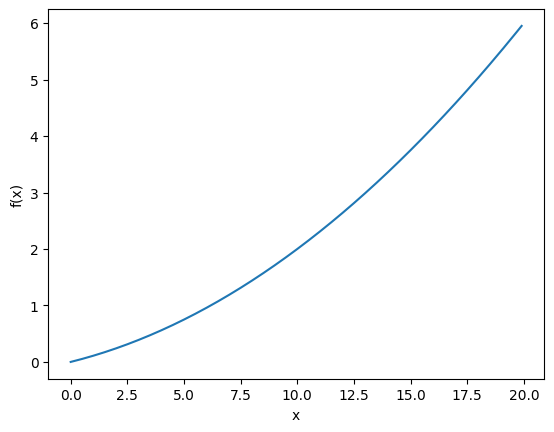

In [ ]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

import numpy as np
import matplotlib.pylab as plt

x = np.arange(0.0, 20.0, 0.1)  # 0에서 20까지 0.1 간격의 배열 x를 만든다(20은 미포함).
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

In [ ]:
numerical_diff(function_1, 5)

0.1999999999990898

In [ ]:
numerical_diff(function_1, 10)

0.2999999999986347

***ch04/gradient_1d.py***

[그림 4-7]의 왼쪽 그래프

0.1999999999990898


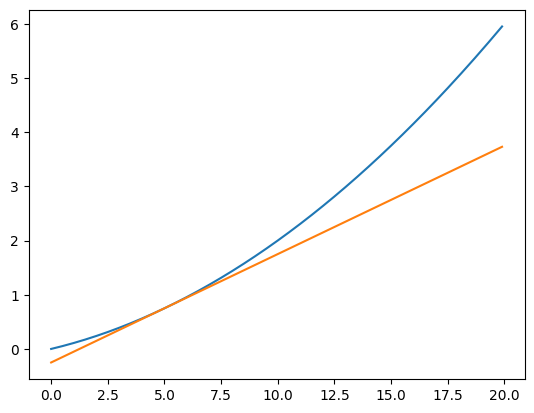

In [ ]:
#접선 추가
def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

tf = tangent_line(function_1, 5)  # x = 5
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)
plt.show()

***ch04/gradient_1d.py***

[그림 4-7]의 오른쪽 그래프

0.2999999999986347


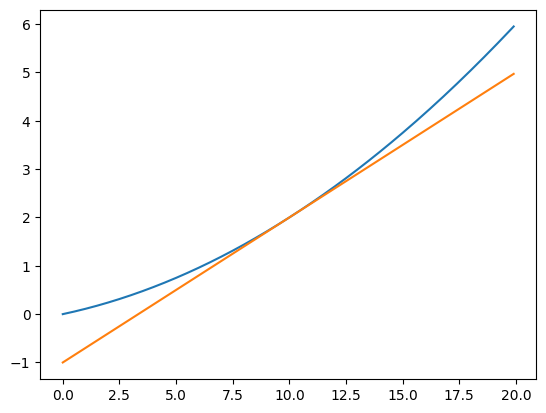

In [ ]:
tf = tangent_line(function_1, 10)  # x = 10
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)
plt.show()

### 4.3.3 편미분

In [ ]:
def function_2(x):
    return x[0]**2 + x[1]**2
    # 또는 return np.sum(x**2)

In [ ]:
def function_tmp1(x0):
    return x0*x0 + 4.0**2.0

numerical_diff(function_tmp1, 3.0)

6.00000000000378

In [ ]:
def function_tmp2(x1):
    return 3.0**2.0 + x1*x1

numerical_diff(function_tmp2, 4.0)

7.999999999999119

## 4.4 기울기

In [ ]:
def numerical_gradient(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)  # x와 형상이 같은 배열을 생성

    for idx in range(x.size):
        tmp_val = x[idx]

        # f(x+h) 계산
        x[idx] = tmp_val + h
        fxh1 = f(x)

        # f(x-h) 계산
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val  # 값 복원

    return grad

In [ ]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

In [ ]:
numerical_gradient(function_2, np.array([0.0, 2.0]))

array([0., 4.])

In [ ]:
numerical_gradient(function_2, np.array([3.0, 0.0]))

array([6., 0.])

***ch04/gradient_2d.py***

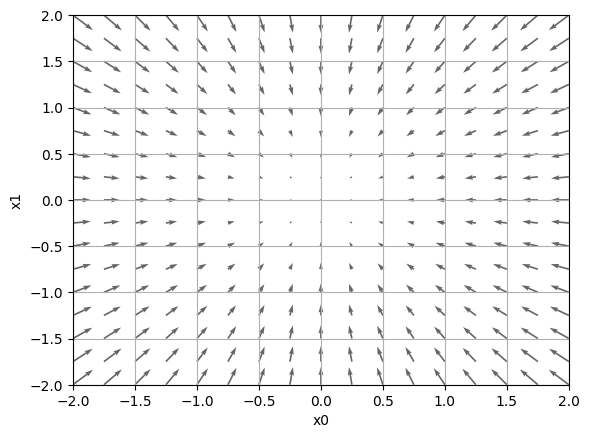

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성

    for idx in range(x.size):
        tmp_val = x[idx]

        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)

        # f(x-h) 계산
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원

    return grad

def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)

        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)

        return grad

def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)

x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([X, Y]))

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.draw()
plt.show()

### 4.4.1 경사법(경사 하강법)

In [ ]:
def gradient_descent(f, init_x, lr= 0.01, step_num = 100):
    x = init_x

    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x

In [ ]:
def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x = init_x, lr = 0.1, step_num = 100)

array([-6.11110793e-10,  8.14814391e-10])

***ch04/gradient_method.py***

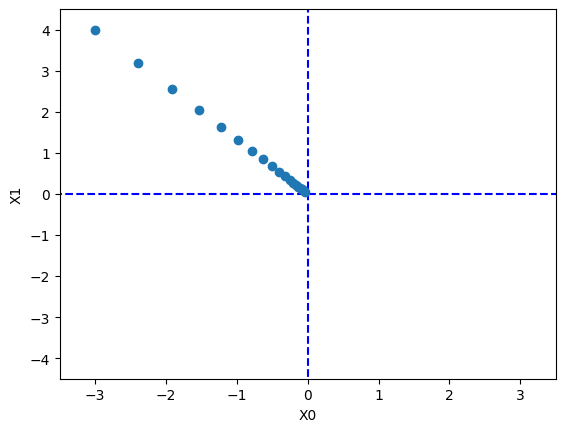

In [ ]:
import numpy as np
import matplotlib.pylab as plt
#from gradient_2d import numerical_gradient

def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)


def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

In [ ]:
# 학습률이 너무 큰 예: lr = 10.0
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x = init_x, lr = 10.0, step_num = 100)

(array([-2.58983747e+13, -1.29524862e+12]),
 array([[-3.00000000e+00,  4.00000000e+00],
        [ 5.70000000e+01, -7.60000000e+01],
        [-1.08300000e+03,  1.44400000e+03],
        [ 2.05770000e+04, -2.74360000e+04],
        [-3.90963008e+05,  5.21284002e+05],
        [ 7.42829664e+06, -9.90439654e+06],
        [-1.41137328e+08,  1.88183103e+08],
        [ 2.68126267e+09, -3.57501690e+09],
        [-5.09763373e+10,  6.79001831e+10],
        [ 9.45170863e+11, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.295

In [ ]:
# 학습률이 너무 작은 예: lr = 1e-10
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x = init_x, lr = 1e-10, step_num = 100)

(array([-2.99999994,  3.99999992]),
 array([[-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  3.99999999],
        [-3.        ,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999998],
        [-2.99999999,  3.99999998],
        [-2.99999999,  3.99999998],
        [-2.99999999,  3.99999998],
        [-2.99999999,  3.99999998],
        [-2.99999999,  3.99999998],
        [-2.99999998,  3.99999998],
        [-2.99999998,  3.999

### 4.4.2 신경망에서의 기울기

***ch04/gradient_simplenet.py***

In [ ]:
import numpy as np
#from common.functions import softmax, cross_entropy_error
#from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3)  # 정규분포로 초기화

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

In [ ]:
net = simpleNet()
print(net.W)  # 가중치 매개변수

[[-1.04040386 -0.33626729  0.32472986]
 [ 0.00956881 -0.35495618 -1.26328324]]


In [ ]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[-0.61563038 -0.52122094 -0.942117  ]


In [ ]:
np.argmax(p)  # 최댓값의 인덱스

1

In [ ]:
t = np.array([0, 0, 1])  # 정답 레이블
net.loss(x, t)

3.016293610052446

In [ ]:
def f(W):
    return net.loss(x, t)

dW = numerical_gradient(f, net.W)
print(dW)

[[-0.5618069   0.10138015  0.46042674]
 [-0.84271034  0.15207023  0.69064011]]


In [ ]:
f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)

## 4.5 학습 알고리즘 구현하기

### 4.5.1 2층 신경망 클래스 구현하기

In [ ]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

***ch04/two_layer_net.py***

In [ ]:
#from common.functions import *
#from common.gradient import numerical_gradient

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size,
                weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)

        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        t = np.argmax(t, axis = 1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    # 성능 개선판
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}

        batch_num = x.shape[0]

        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)

        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [ ]:
net = TwoLayerNet(input_size = 784, hidden_size = 100, output_size = 10)
net.params['W1'].shape  # (784, 100)

(784, 100)

In [ ]:
net.params['b1'].shape  # (100,)

(100,)

In [ ]:
net.params['W2'].shape  # (100, 10)

(100, 10)

In [ ]:
net.params['b2'].shape  # (10,)

(10,)

In [ ]:
x = np.random.rand(100, 784)  # 더미 입력 데이터(100장 분량)
y = net.predict(x)

In [ ]:
x = np.random.rand(100, 784)  # 더미 입력 데이터(100장 분량)
t = np.random.rand(100, 10)   # 더미 정답 레이블(100장 분량)

grads = net.numerical_gradient(x, t)  # 기울기 계산

grads['W1'].shape  # (784, 100)

(784, 100)

In [ ]:
grads['b1'].shape  # (100,)

(100,)

In [ ]:
grads['W2'].shape  # (100, 10)

(100, 10)

In [ ]:
grads['b2'].shape  # (10,)

(10,)

### 4.5.2 미니배치 학습 구현하기

***ch04/train_neuralnet_1.py***

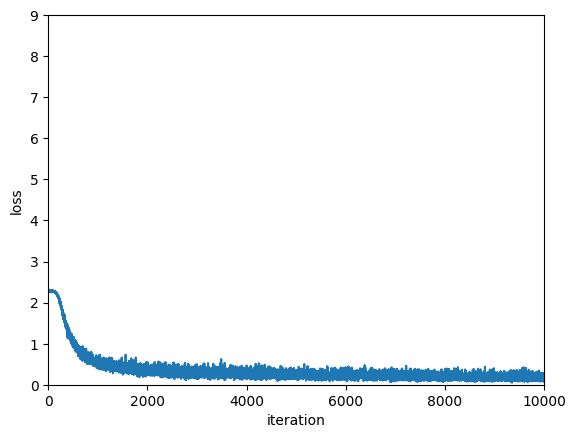

In [ ]:
import numpy as np
#from dataset.mnist import load_mnist
#from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize = True, one_hot_label = True)

train_loss_list = []

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1
network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)  # 성능 개선판!

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

# 그래프 그리기
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.ylim(0, 9)
plt.xlim(0, 10000)
plt.show()

### 4.5.3 시험 데이터로 평가하기

***ch04/train_neuralnet_2.py***

train acc, test acc | 0.10218333333333333, 0.101
train acc, test acc | 0.7850833333333334, 0.7909
train acc, test acc | 0.8750833333333333, 0.8787
train acc, test acc | 0.8989666666666667, 0.9003
train acc, test acc | 0.9088333333333334, 0.9118
train acc, test acc | 0.9146833333333333, 0.9172
train acc, test acc | 0.919, 0.9211
train acc, test acc | 0.9231166666666667, 0.926
train acc, test acc | 0.9265, 0.9287
train acc, test acc | 0.9299333333333333, 0.9318
train acc, test acc | 0.9332, 0.9343
train acc, test acc | 0.9359833333333333, 0.9374
train acc, test acc | 0.9382166666666667, 0.9382
train acc, test acc | 0.9407333333333333, 0.9393
train acc, test acc | 0.9433666666666667, 0.9416
train acc, test acc | 0.9448833333333333, 0.9445
train acc, test acc | 0.9469166666666666, 0.9446


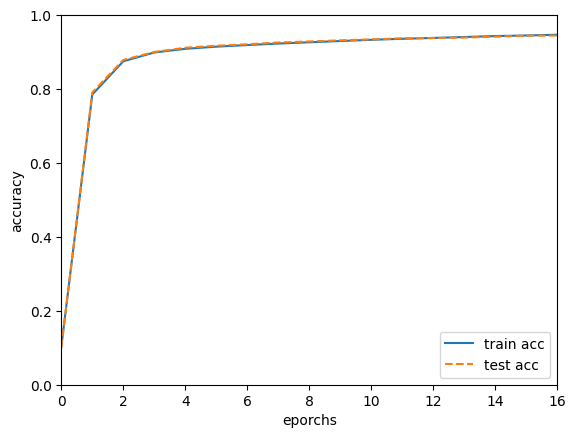

In [ ]:
import numpy as np
#from dataset.mnist import load_mnist
#from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize = True, one_hot_label = True)

network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)  # 성능 개선판!

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | "
            + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("eporchs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.xlim(0, 16)
plt.legend(loc='lower right')
plt.show()